In [142]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
"""
source @gemini 3 pro
"""

# --- CONFIGURATION ---
DATASET_DIR = r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\data\segmentation_dataset"
IMGS_DIR = Path(DATASET_DIR) / "imgs"
MASKS_DIR = Path(DATASET_DIR) / "masks"

def load_random_pair():
    """Charge une image et son masque aléatoire du dataset"""
    all_imgs = list(IMGS_DIR.glob("*.jpg"))
    if not all_imgs:
        raise FileNotFoundError(f"Aucune image trouvée dans {IMGS_DIR}")
    
    img_path = random.choice(all_imgs)
    mask_path = MASKS_DIR / img_path.name.replace(".jpg", ".png")
    
    # Lecture
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    return image, mask, img_path.name

def visualize(image, mask, original_image=None, original_mask=None, title="Augmentation"):
    """Affiche l'image originale et l'augmentée côte à côte"""
    fontsize = 12
    
    if original_image is None:
        f, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].set_title('Image', fontsize=fontsize)
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Masque', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 2, figsize=(10, 10))
        
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)
        
        ax[0, 1].imshow(original_mask, cmap='gray')
        ax[0, 1].set_title('Original Mask', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title(f'Augmented: {title}', fontsize=fontsize)
        
        ax[1, 1].imshow(mask, cmap='gray')
        ax[1, 1].set_title('Augmented Mask', fontsize=fontsize)
        
    plt.tight_layout()
    plt.show()

print("Configuration chargée.")


Configuration chargée.


In [143]:
# Définition des transformations
# La probabilité p=1 assure qu'on applique la transformation pour voir l'effet ici.
# Dans le vrai training, on mettra p=0.5.
# Définition des transformations (Version Corrigée pour Albumentations récent)

transform_pipeline = A.Compose([
    
    # --- 1. GÉOMÉTRIE ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=180, p=0.7, border_mode=cv2.BORDER_CONSTANT), 
    
    # Déformation élastique légère (simule le mouvement de l'eau/corps mous)
    A.ElasticTransform(alpha=1, sigma=30, p=0.3), 

    # --- 2. ARTEFACTS (NOUVEAU) ---
    # Simule des poussières / saletés sur l'objectif ou dans l'eau
    # On crée entre 1 et 15 petits points noirs (ou gris foncé)
    A.CoarseDropout(
        max_holes=8,       # Max nb de poussières
        min_holes=2,        # Min nb de poussières
        max_height=8,      # Taille max (pixels)
        max_width=8, 
        min_height=2,       # Taille min (pixels)
        min_width=2,
        fill_value=0,       # 0 = Noir (poussière opaque), ou mettre 'random'
        mask_fill_value=None, # Ne touche pas au masque ! (IMPORTANT)
        p=0.6
    ),

    # --- 3. DÉGRADATION & BRUIT ---
    
    # Réduction de résolution (simule une optique bas de gamme)
    A.Downscale(scale_range=(0.8, 0.95), p=0.4),
    
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.5),   
        A.GaussianBlur(blur_limit=(3, 3), p=0.5), 
    ], p=0.3),
    
    # Bruit de capteur (Remplacement de GaussNoise pour éviter l'erreur)
    A.OneOf([
        # Simulation de bruit ISO (grain photo) - très réaliste
        A.ISONoise(color_shift=(0.01, 0.02), intensity=(0.05, 0.3), p=0.5),
        
        # Bruit multiplicatif (variation de sensibilité locale)
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), elementwise=True, p=0.5),
    ], p=0.5),

    # Compression JPEG (Artefacts de blocs carrés)
    A.ImageCompression(quality_range=(70, 95), p=0.4),

    # --- 4. LUMIÈRE ---
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),
    
    # --- 5. FINITION : FORCER LE GRIS ---
    # Convertit tout (y compris le bruit coloré ISO) en gris pur
    A.ToGray(p=1.0),
    
], is_check_shapes=False)


print("Pipeline de transformation prêt.")


Pipeline de transformation prêt.


C:\Users\223120964.HCAD\AppData\Local\Temp\ipykernel_15016\2796520297.py:19: UserWarning: Argument(s) 'max_holes, min_holes, max_height, max_width, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Image: cyphonaute__84967__335528097.jpg


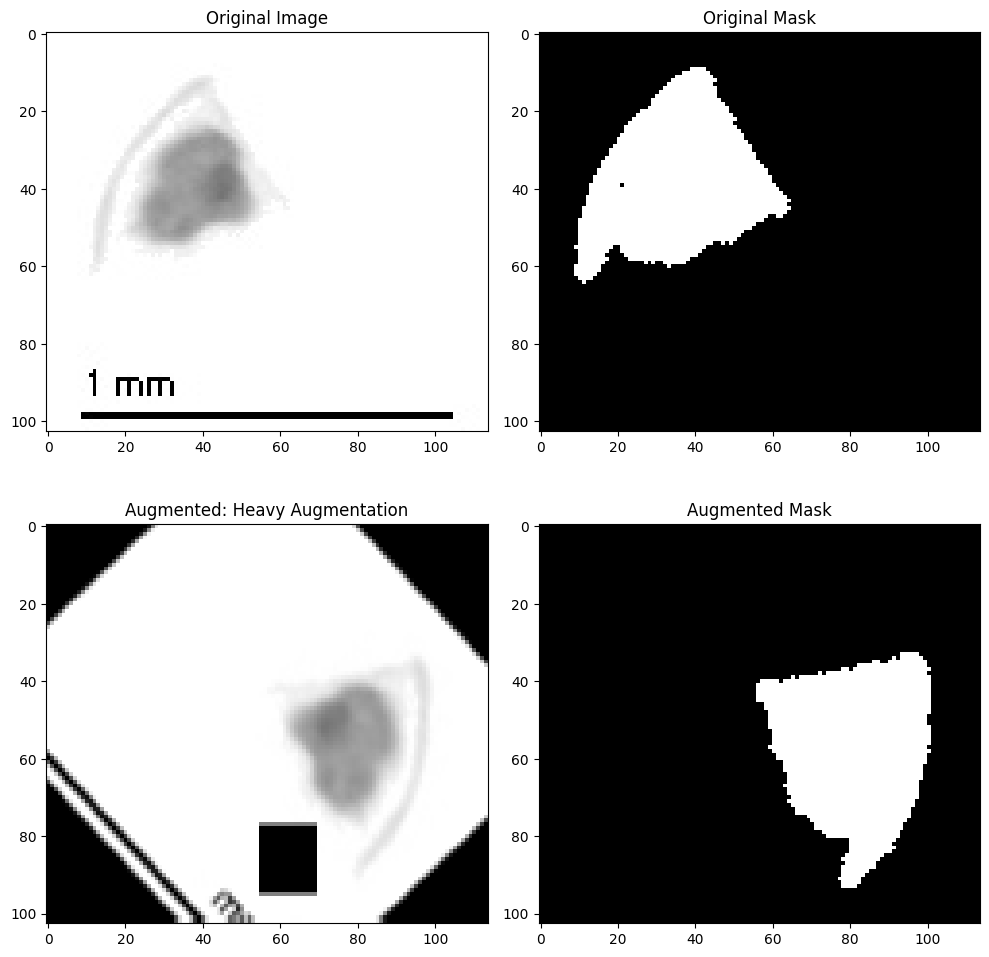

In [144]:
# Charger une paire aléatoire
image, mask, name = load_random_pair()

# Appliquer les augmentations
# Albumentations demande des arguments nommés
augmented = transform_pipeline(image=image, mask=mask)

image_aug = augmented['image']
mask_aug = augmented['mask']

# Visualiser
print(f"Image: {name}")
visualize(image_aug, mask_aug, original_image=image, original_mask=mask, title="Heavy Augmentation")


C:\Users\223120964.HCAD\AppData\Local\Temp\ipykernel_15016\556571881.py:6: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=1) # Simule des débris ou occlusions


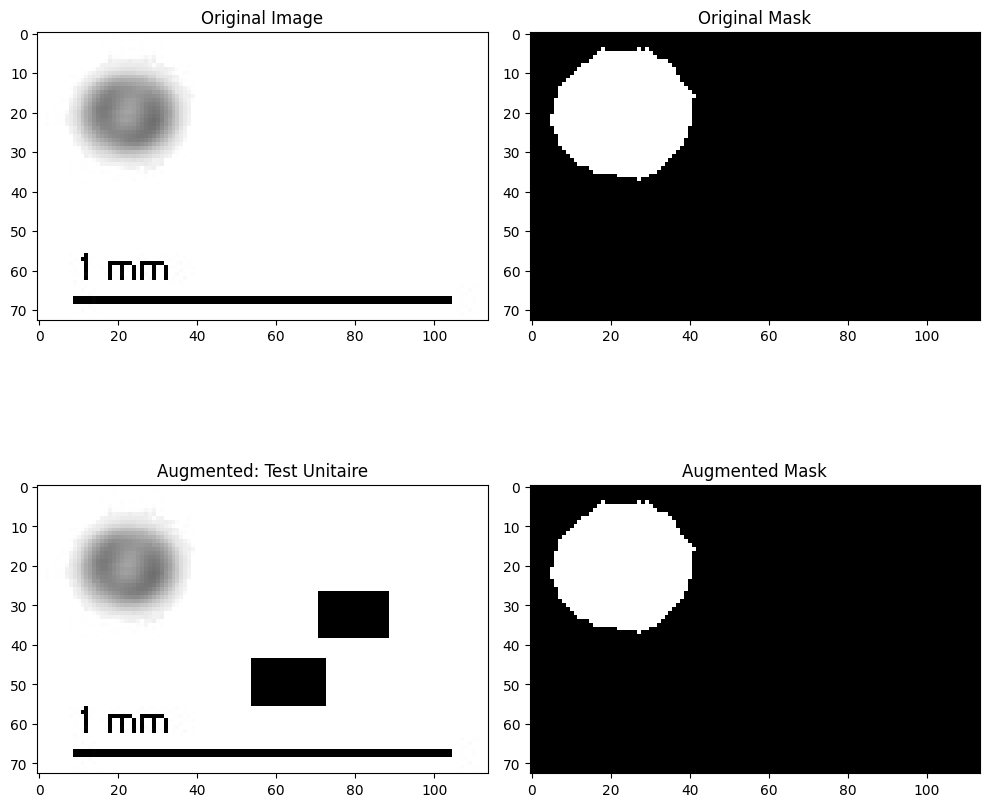

In [145]:
# Test unitaire d'une transformation spécifique
specific_transform = A.Compose([
    # Change cette ligne pour tester autre chose :
    # A.Downscale(scale_min=0.2, scale_max=0.2, p=1)
    # A.ImageCompression(quality_lower=5, quality_upper=10, p=1)
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=1) # Simule des débris ou occlusions
])

image, mask, name = load_random_pair()
augmented = specific_transform(image=image, mask=mask)

visualize(augmented['image'], augmented['mask'], original_image=image, original_mask=mask, title="Test Unitaire")
